### PAVICS WPS workflow 
##### In this example we will chain PAVICS wps calls together to create a hypothetical data analysis workflow
We will try to accomplish the following tasks - all carried out on the PAVICS server:
1. search for netcdf files using the PAVICS catalogue (we'll use some ClimEX data)
* spatially subset the data for a zone over southern Quebec
* temporally concatenate subsetted files into a single time-series
* calculate a climate index (monthly maximum)
* download the resulting .nc locally and make a plot 

In this example we will use three different PAVICS WPS suites
* PAVICS catalogue : https://pavics.ouranos.ca/twitcher/ows/proxy/catalog/pywps
* Flyingpigeon suite : https://pavics.ouranos.ca/twitcher/ows/proxy/flyingpigeon/wps 
* Hummingbird suite : https://pavics.ouranos.ca/twitcher/ows/proxy/hummingbird/wps


#### Imports


In [1]:
from netCDF4 import Dataset
import requests
import xml.etree.ElementTree as ET   
import matplotlib.pyplot as plt
from owslib.wps import WebProcessingService, ComplexDataInput 



####1 - search for datasets using the Catalogue

In [2]:
# catalogue WPS url
wpsURL = 'https://pavics.ouranos.ca/twitcher/ows/proxy/catalog/pywps'

# Connection 
wpsCatalogue = WebProcessingService(url=wpsURL)

##### 1.1 List available catalogue processes

In [3]:
for process in wpsCatalogue.processes:
    print ('%s \t : %s \n' %(process.identifier, process.abstract))

getpoint 	 : Return a single value from a NetCDF file at the given grid coordinates. 

ncplotly 	 : Return a dictionary storing the data necessary to create a simple plotly time series. 

pavicrawler 	 : Crawl thredds server and write metadata to SOLR database. 

pavicsearch 	 : Search the PAVICS database and return a catalogue of matches. 

pavicsupdate 	 : Update database entries using key:value pairs and identified by their ids. 

pavicsvalidate 	 : Query database entries for missing required facets. 

period2indices 	 : The final index is inclusive. 

pavicstestdocs 	 : Add test documents to Solr index. 



#####1.2 we want the 'pavicsearch' process
* let's describe the process first 

In [4]:
proc_name = 'pavicsearch'
process = wpsCatalogue.describeprocess(proc_name) # get process info
for i in process.dataInputs:
    print('inputs :', i.identifier, ' : ', i.abstract)
for i in process.processOutputs:
    print('outputs :', i.identifier, ' : ', i.abstract)

inputs : facets  :  Comma separated list of facets; facets are searchable indexing terms in the database.
inputs : shards  :  Shards to be queried
inputs : offset  :  Where to start in the document count of the database search.
inputs : limit  :  Maximum number of documents to return.
inputs : fields  :  Comme separated list of fields to return.
inputs : format  :  Output format.
inputs : query  :  Direct query to the database.
inputs : distrib  :  Distributed query
inputs : type  :  One of Dataset, File, Aggregate or FileAsAggregate.
inputs : constraints  :  Format is facet1:value1,facet2:value2,...
inputs : esgf  :  Whether to also search ESGF nodes.
inputs : list_type  :  Can be opendap_url, fileserver_url, gridftp_url, globus_url, wms_url
outputs : search_result  :  PAVICS Catalogue Search Result
outputs : list_result  :  List of urls of the search result.


#####1.3 Search for NRCAN data - variable tasmax

In [63]:
# built Constraint string  variable = 'tasmax'  
proc_name = 'pavicsearch'
constraintString = 'variable:tasmax'
maxfiles = '1000000'
myinputs = [('constraints', constraintString),('type','File'), ('limit',maxfiles)]
execution = wpsCatalogue.execute(identifier=proc_name, inputs=myinputs)
print(execution.status)
print(execution.processOutputs[-1].reference)


ProcessSucceeded
None


In [34]:
# Same workaround here - execution.processOutputs[-1].reference is none (?)
o = requests.get(execution.statusLocation)
tree = ET.fromstring(o.content)
for child in tree:
    if 'ProcessOutputs' in child.tag:
        for c in child:
            if 'Output' in c.tag:
                for cc in c:
                    if 'Reference' in cc.tag:
                        r = requests.get(cc.get('{http://www.w3.org/1999/xlink}href'))
                        #print(r.content)

list_nc = r.json()
print('Numer of files found :',len(list_nc), '\n')
print(list_nc[1:15],'...')

Numer of files found : 13026 

['https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r3i1p1/tasmax/tasmax_kdc_198902_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r1i1p1/tasmax/tasmax_kda_206005_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/cb-oura-1.0/HadGEM2-CC/rcp45/day/tasmax/tasmax_day_HadGEM2-CC_rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_2043.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r2i1p1/tasmax/tasmax_kdb_202907_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r1i1p1/tasmax/tasmax_kda_200310_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d

#####1.4 We have a lot of files - Let's filter for NRCAN anusplin
* Filter the list for only 'nrcan'
* Get only a 3 years of data - 1981 to 1983 (more manageable for today)
* Files are not in sequential order - use sort() to clean up the list


In [36]:
# filter netcdf_file list
nrcan_nc = [i for i in list_nc if 'nrcan' in i and ('1981' in i or '1982' in i or '1983' in i)]
# sort the filtered list
nrcan_nc.sort()

print('Number of files :', len(nrcan_nc),nrcan_nc)



Number of files : 3 ['https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily/tasmax/nrcan_canada_daily_tasmax_1981.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily/tasmax/nrcan_canada_daily_tasmax_1982.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily/tasmax/nrcan_canada_daily_tasmax_1983.nc']


##### End step 1 - Successful search and filtering of datasets	
##### PAVICS user level 0 : Use OpenDap urls to access the data
* Does not leverage any computing power
* Roughly equivalent to Web Coverage Service (i.e. access remote data on the server but process on local machine)

In [37]:

nc_test = Dataset(nrcan_nc[0])
print(nc_test)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: CF-1.5
    title: NRCAN 10km Gridded Climate Dataset
    history: 2012-10-22T10:44:52: Convert from original format to NetCDF
    institution: NRCAN
    source: ANUSPLIN
    redistribution: Redistribution policy unknown. For internal use only.
    DODS_EXTRA.Unlimited_Dimension: time
    dimensions(sizes): time(365), lat(510), lon(1068), ts(3)
    variables(dimensions): float32 lon(lon), float32 lat(lat), int16 ts(ts), int16 time(time), int16 time_vectors(time,ts), float32 tasmax(time,lat,lon)
    groups: 



### Step 2 - spatial subset the ncfiles
* let's try to learn how to use WPS more efficiently
* subsetting functions can be found in Flyingpigeon 
* fist step initiate connection to flyingpigeon 


In [38]:
wpsURL = 'https://pavics.ouranos.ca/twitcher/ows/proxy/flyingpigeon/wps'
wpsFP = WebProcessingService(url=wpsURL,verbose=False, skip_caps=False)
print(wpsFP.identification.title)

Flyingpigeon 1.1_dev


##### 2.1 List available flyingpigeon processes

In [39]:
for process in wpsFP.processes:
    print ('%s \t : %s \n' %(process.identifier, process.abstract))

subset_countries 	 : Return the data whose grid cells intersect the selected countries for each input dataset. 

subset_continents 	 : Return the data whose grid cells intersect the selected continents for each input dataset. 

subset_regionseurope 	 : Return the data whose grid cells inteserct the selected regions for each input dataset. 

pointinspection 	 : Extract the timeseries at the given coordinates. 

landseamask 	 : Mask grid cells according to their land area fraction. This process uses the ESGF datastore to access an appropriate land/sea mask. 

fetch_resources 	 : Fetch data resources (limited to 50GB) to the local filesystem of the birdhouse compute provider. 

indices_percentiledays 	 : Climatological percentile for each day of the year computed over the entire dataset. 

indices_single 	 : Climate index calculated from one daily input variable. 

sdm_gbiffetch 	 : Species occurence search in Global Biodiversity              Infrastructure Facillity (GBIF) 

sdm_getindic

#####2.2 Flyingpigeon does a lot - use 'subset_bbox' process for now
* let's describe the process first

In [40]:
proc_name = 'subset_bbox'
process = wpsFP.describeprocess(proc_name)
print(process.title,' : ',process.abstract,'\n')
for i in process.dataInputs:
    print('inputs :', i.identifier, ' : ', i.abstract)
for i in process.processOutputs:
    print('outputs :', i.identifier, ' : ', i.abstract)

Subset  :  Return the data for which grid cells intersect the bounding box for each input dataset as well asthe time range selected. 

inputs : resource  :  NetCDF files, can be OPEnDAP urls.
inputs : lon0  :  Minimum longitude.
inputs : lon1  :  Maximum longitude.
inputs : lat0  :  Minimum latitude.
inputs : lat1  :  Maximum latitude.
inputs : initial_datetime  :  Initial datetime for temporal subsetting.
inputs : final_datetime  :  Final datetime for temporal subsetting.
inputs : variable  :  Name of the variable in the NetCDF file.Will be guessed if not provided.
outputs : output  :  JSON file with link to NetCDF outputs.


#####2.3 Create WPS inputs and execute WPS
This time we will have multiple 'resource' inputs 
* Subset multiple .nc files with one WPS call 
* Subset only using lat lon bounds - other inputs left blank

In [41]:
myinputs = []
# To keep things reasonably quick : subset jan-april
for i in nrcan_nc: 
    myinputs.append(('resource', i))
myinputs.append(('lon0', '-80.0'))
myinputs.append(('lon1', '-70.0'))
myinputs.append(('lat0', '44.0'))
myinputs.append(('lat1', '50'))
print(myinputs)

[('resource', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily/tasmax/nrcan_canada_daily_tasmax_1981.nc'), ('resource', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily/tasmax/nrcan_canada_daily_tasmax_1982.nc'), ('resource', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily/tasmax/nrcan_canada_daily_tasmax_1983.nc'), ('lon0', '-80.0'), ('lon1', '-70.0'), ('lat0', '44.0'), ('lat1', '50')]


In [42]:
# This could take a some time
execution = wpsFP.execute(identifier=proc_name, inputs=myinputs)
print(execution.status)
print(execution.processOutputs[-1].reference)
print(execution.statusLocation)

ProcessSucceeded
None
https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/1cf6b5ae-b82c-11e8-b251-0242ac12000b.xml


In [43]:
o = requests.get(execution.statusLocation)
tree = ET.fromstring(o.content)
for child in tree:
    if 'ProcessOutputs' in child.tag:
        for c in child:
            if 'Output' in c.tag:
                for cc in c:
                    if 'Reference' in cc.tag:
                        r = requests.get(cc.get('{http://www.w3.org/1999/xlink}href'))
                        #print(r.content)

list_subset = r.json()
print(list_subset)

['https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/tmpeOHNr5/nrcan_canada_daily_tasmax_1981_subset.nc', 'https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/tmpeOHNr5/nrcan_canada_daily_tasmax_1982_subset.nc', 'https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/tmpeOHNr5/nrcan_canada_daily_tasmax_1983_subset.nc']


#####2.4 subset completed
Before moving on - Let's download one file to see how the subset worked

In [44]:
r = requests.get(list_subset[0])
outfile = './output/' +list_subset[0].split('/')[-1] 
print(outfile)
with open(outfile, 'wb') as f:
    f.write(r.content)

./output/nrcan_canada_daily_tasmax_1981_subset.nc


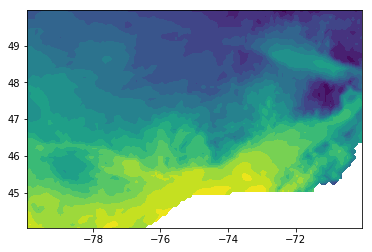

In [45]:
nc1 = Dataset(outfile)
tasmax = nc1.variables['tasmax'][:]
lon = nc1.variables['lon'][:]
lat = nc1.variables['lat'][:]
plt.contourf(lon,lat,tasmax.mean(axis=0),20)


#####Looks good - the St-Lawrence valley is visible (if you are familiar with Quebec geography)
##### End step 2 - Successful spatial subsetting of datasets	

### Step 3 - temporal concatenation using 'ncmerge'
* 'ncmerge' can also be accessed in Flyingpigeon 
 

##### As always : start by describing the process

In [46]:
proc_name = 'ncmerge'
process = wpsFP.describeprocess(proc_name) # get process info
for i in process.dataInputs:
    print('inputs :', i.identifier, ' : ', i.abstract)
for i in process.processOutputs:
    print('outputs :', i.identifier, ' : ', i.abstract)

inputs : resource  :  NetCDF files, can be OPEnDAP urls.
outputs : output  :  Temporally merged NetCDF files.


#####3.1 Question : Are my subsetted urls (list_subset) opendap urls?
* Simple test : follow one of the links
* If you start to download : Not OpenDAP


In [47]:
#Check if opendap
import webbrowser
print(list_subset[0])
webbrowser.open_new(list_subset[0])

https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/tmpeOHNr5/nrcan_canada_daily_tasmax_1981_subset.nc


True


#####3.2 Test conclusion : The subsetted .nc urls are NOT OpenDAP
* Future development - we would like to get both OpenDap and direct links as outputs from PAVICS

#####3.3 We can still use them but resouce inputs must be sent using ComplexDataInput()
* Create inputs list and execute WPS


In [67]:
proc_name = 'ncmerge'
myinputs = []
for l in list_subset:
    #print(l)
    myinputs.append(('resource', ComplexDataInput(l)))
print(myinputs)


ProcessSucceeded
https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/06c12b18-b82f-11e8-b251-0242ac12000b.xml


In [68]:
execution = wpsFP.execute(
    identifier=proc_name,
    inputs=myinputs, )
print(execution.status)
#print(execution.processOutputs[-1].reference)
print(execution.statusLocation)



ProcessSucceeded
https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/06c12b18-b82f-11e8-b251-0242ac12000b.xml


##### 3.3 Get WPS output location and download merged .nc file 


In [69]:
print(execution.statusLocation)
o = requests.get(execution.statusLocation)
tree = ET.fromstring(o.content)
for child in tree:
    if 'ProcessOutputs' in child.tag:
        for c in child:
            if 'Output' in c.tag:
                for cc in c:
                    if 'Reference' in cc.tag:
                        merged_nc = cc.get('{http://www.w3.org/1999/xlink}href')
                        #print(r.content)
r = requests.get(merged_nc)
print('This is the url to the merged file :',merged_nc)
outfile_merge = './output/' + merged_nc.split('/')[-1] 
print(outfile_merge)
with open(outfile_merge, 'wb') as f:
    f.write(r.content)

https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/06c12b18-b82f-11e8-b251-0242ac12000b.xml


This is the url to the merged file : https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/06c12b18-b82f-11e8-b251-0242ac12000b/nrcan_canada_daily_tasmax_1981_subset_merged_UwgXPF.nc
./output/nrcan_canada_daily_tasmax_1981_subset_merged_UwgXPF.nc


#####3.4 Make a plot : we should have 3 years of data

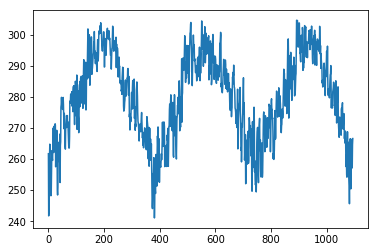

In [73]:
ncOut = Dataset(outfile_merge)
#print(ncOut)

tasmax_merge = ncOut.variables['tasmax'][:]
plt.plot(tasmax_merge[:,10,10])

##### End step 3 - Successful temporal merge

### Step 4 - Calculate monthly maximums  
1. Use CDO operators via Hummingbird - A different WPS suite

#####4.1 Let's start with connecting to Hummingbird
##### As always : start by describing the process


In [86]:
wpsURL = 'https://boreas.ouranos.ca/twitcher/ows/proxy/hummingbird/wps'
wpsHM = WebProcessingService(url=wpsURL)
print(wpsHM.identification.title)

CDO Operation  :  Calls CDO operations like monmax on a NetCDF file. 

inputs : dataset  :  You may provide a URL or upload a NetCDF file.
inputs : dataset_opendap  :  Or provide a remote OpenDAP data URL, for example: http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis2.dailyavgs/surface/mslp.2016.nc
inputs : operator  :  Choose a CDO Operator.                          See the CDO documentation to lookup a description of the operators.
outputs : output  :  NetCDF Output generated by CDO.


#####4.2 List WPS services available in Hummingbird


In [98]:
for process in wpsHM.processes:
    print ('%s \t : %s ' %(process.identifier, process.abstract))


ncdump 	 : Run ncdump to retrieve NetCDF header metadata. 
spotchecker 	 : Checks a single uploaded or remote dataset against a variety of compliance standards. The dataset is either in the NetCDF format or a remote OpenDAP resource. Available compliance standards are the Climate and Forecast conventions (CF) and project specific rules for CMIP6 and CORDEX. 
cchecker 	 : Runs the IOOS Compliance Checker tool to check datasets against compliance standards. Each compliance standard is executed by a Check Suite, which functions similar to a Python standard Unit Test. A Check Suite runs one or more checks against a dataset, returning a list of Results which are then aggregated into a summary. Development and maintenance for the compliance checker is done by the Integrated Ocean Observing System (IOOS). 
cfchecker 	 : The NetCDF Climate Forcast Conventions compliance checker by CEDA. This process allows you to run the compliance checker to check that the contents of a NetCDF file comply wit

#####4.3 We want to use 'CDO operation'
* As always we start by ...... Describing the process!

In [99]:

proc_name = 'cdo_operation'
process = wpsHM.describeprocess(proc_name) # get process info
print(process.title, ' : ',process.abstract,'\n')
for i in process.dataInputs:
    print('inputs :', i.identifier, ' : ', i.abstract)
for i in process.processOutputs:
    print('outputs :', i.identifier, ' : ', i.abstract)


CDO Operation  :  Calls CDO operations like monmax on a NetCDF file. 

inputs : dataset  :  You may provide a URL or upload a NetCDF file.
inputs : dataset_opendap  :  Or provide a remote OpenDAP data URL, for example: http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis2.dailyavgs/surface/mslp.2016.nc
inputs : operator  :  Choose a CDO Operator.                          See the CDO documentation to lookup a description of the operators.
outputs : output  :  NetCDF Output generated by CDO.


#####4.4 Create inputs & execute WPS


In [91]:
myinputs = []
myinputs.append(('dataset',ComplexDataInput(merged_nc)))
myinputs.append(('operator','monmax'))

execution = wpsHM.execute(identifier=proc_name,inputs=myinputs )
print(execution.status)
print(execution.statusLocation)

ProcessSucceeded
https://pavics.ouranos.ca:443/wpsoutputs/hummingbird/b9fc6b4c-b844-11e8-91d6-0242ac12000d.xml


#####4.5 Download the output


In [100]:

print(execution.statusLocation)
o = requests.get(execution.statusLocation)
tree = ET.fromstring(o.content)
for child in tree:
    if 'ProcessOutputs' in child.tag:
        for c in child:
            if 'Output' in c.tag:
                for cc in c:
                    if 'Reference' in cc.tag:
                        monmax_nc = cc.get('{http://www.w3.org/1999/xlink}href')
                        #print(r.content)
print(monmax_nc)
r = requests.get(monmax_nc)

outfile_monmax = './output/' + monmax_nc.split('/')[-1] 
print(outfile_monmax)
with open(outfile_monmax, 'wb') as f:
    f.write(r.content)


https://pavics.ouranos.ca:443/wpsoutputs/hummingbird/b9fc6b4c-b844-11e8-91d6-0242ac12000d.xml
https://pavics.ouranos.ca:443/wpsoutputs/hummingbird/b9fc6b4c-b844-11e8-91d6-0242ac12000d/cdo_monmax_uP6bgl.nc
./output/cdo_monmax_uP6bgl.nc


#####4.6 Plot the results and compare with daily data series


./output/nrcan_canada_daily_tasmax_1981_subset_merged_UwgXPF.nc
./output/cdo_monmax_uP6bgl.nc


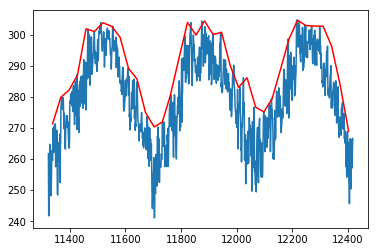

In [110]:
ncMerge = Dataset(outfile_merge)
print(outfile_merge)
ncMax = Dataset(outfile_monmax)
print(outfile_monmax)

tasmax_merge = ncMerge['tasmax'][:]
time_merge = ncMerge['time'][:]
plt.plot(time_merge,tasmax_merge[:,10,10])

tasmax_monmax = ncMax['tasmax'][:]
time_max = ncMax['time'][:]
plt.plot(time_max,tasmax_monmax[:,10,10],color='r')
